In [14]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import minimize
from scipy import optimize

import RMcalc
from matplotlib.ticker import EngFormatter, StrMethodFormatter

In [19]:
c=3*10**8 #m/s
res = 5 #size of the frequency bin in MHz
fmin=1150
fmax=1650

f = np.arange(fmin, fmax, res) # SKA low from 50 to 350 MHz with 1Hz frequency resolution
lam = c/f/1e6 #wavelength

print("sampling freq: ", res)
f_mean = np.arange(fmin, fmax, res)
lam_mn = c/f_mean/1e6 #wavelength
lam2_mn = lam_mn**2

RM = 10 #rad/m^2
phi = np.random.uniform(0, 2*np.pi)
p = 0.8 #fraction of polarisation
I = 1 #for simplicity
snr = 10


phi = 0.1#10*lam**(-0.3)
Q = I*p*np.cos(2*RM*lam**2 + phi) + np.random.randn(len(lam))/snr #Add your signal here
U = I*p*np.sin(2*RM*lam**2 + phi) + np.random.randn(len(lam))/snr #Add your signal here

sampling freq:  5


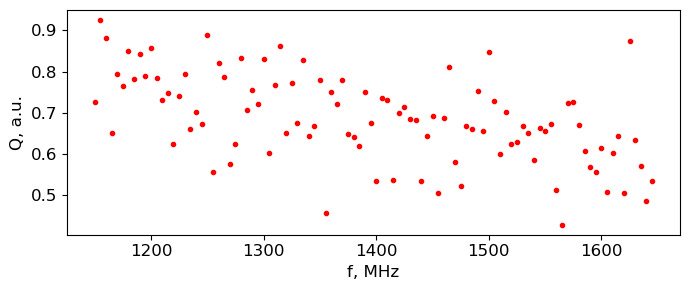

In [20]:
fig = plt.figure(figsize=(7, 3))
plt.plot(f_mean,U, ".", color="red")
#plt.plot(fmod, 100*Umod, alpha=0.4)
plt.xlabel("f, MHz", fontsize=12)
plt.ylabel("Q, a.u.", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

Initial eta2: 0.79


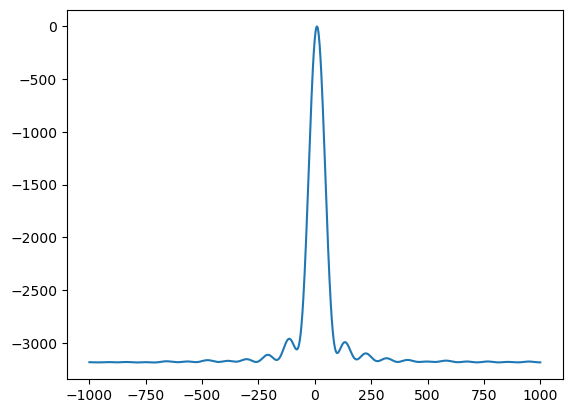

Determined RM: 9.309309
RM bglsp uncertainty: 0.558615 eta2: 0.79


/tmp/ipykernel_38014/4187371622.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Determined RM: %.6f" % (RM_bgls))


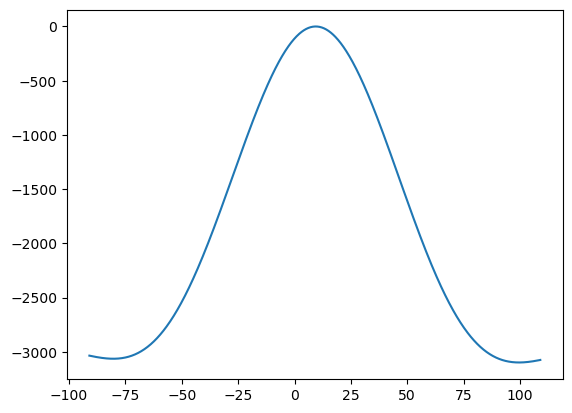

In [21]:
#calculating the RM
init_width_factor = 100
err_rmsyn = 1.0
ofac=1000

lam2_mn = lam_mn**2
lam2_mn = lam2_mn -np.mean(lam2_mn)
qerr = np.ones(len(Q))/snr
uerr = np.ones(len(U))/snr


RMlist,p,logp,exp,eta = RMcalc.RM_bglsp(lam2_mn, Q, qerr, U, uerr, -1000, 1000, ofac=1000, remove_baseline="False")

print("Initial eta2: %.2f" % (eta))

#Determine the maximum of the peak and its frequency
RM_bgls = RMlist[np.array(logp)==np.max(logp)]
eta2 = -exp[np.array(logp)==np.max(logp)]*2./(2.*len(lam2_mn)-4)

plt.plot(RMlist, logp)
plt.show()

RM_bgls=RM_bgls[0]
RM_list_bgls, p, logp, exponents, eta2=RMcalc.RM_bglsp(lam2_mn, Q, qerr, U, uerr, RM_bgls-init_width_factor*err_rmsyn, RM_bgls+init_width_factor*err_rmsyn, ofac=ofac, remove_baseline="False")
RM_bgls = RM_list_bgls[np.array(logp)==np.max(logp)]


err_bgls=RMcalc.fwhm(RM_list_bgls, p)*np.sqrt(eta2)

print("Determined RM: %.6f" % (RM_bgls))
print("RM bglsp uncertainty: %.6f eta2: %.2f" % (err_bgls, eta2))

plt.plot(RM_list_bgls, logp)
plt.show()

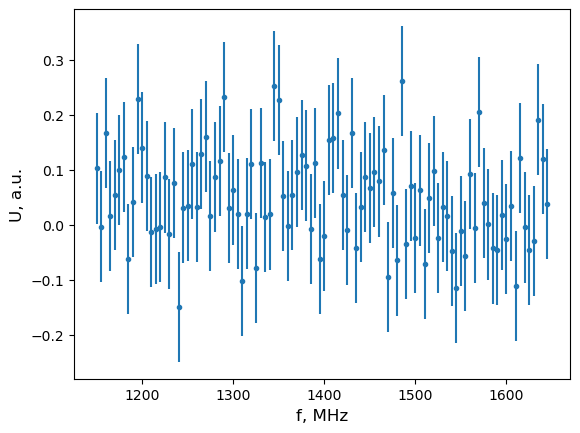

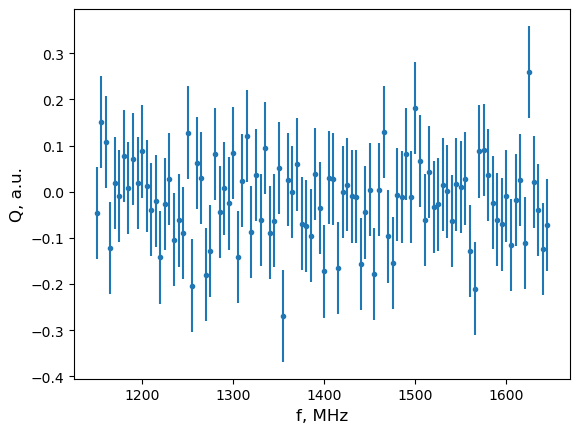

In [22]:
bounds=[(-10,10),(0,2*np.pi)]

def log_likelihood(theta, x, y, yerr, RM):
    A, phi = theta
    model = A*np.sin(2*RM*lam**2 + phi)
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def eggholder(x, lam, dat, daterr, RM_bgls):
    return -log_likelihood([x[0], x[1]], lam, dat, daterr, RM_bgls)
#optimisation for Q
results = optimize.differential_evolution(eggholder, bounds, args=(lam, Q, qerr, RM_bgls))    
x_det = results["x"]
residuals= Q - x_det[0]*np.sin(2*RM*lam**2 + x_det[1])

plt.errorbar(f_mean, residuals, qerr, fmt=".")
plt.xlabel("f, MHz", fontsize=12)
plt.ylabel("U, a.u.", fontsize=12)
plt.show()

#optimization for U
results = optimize.differential_evolution(eggholder, bounds, args=(lam, U, uerr, RM_bgls))    
x_det = results["x"]
residuals= U - x_det[0]*np.sin(2*RM*lam**2 + x_det[1])

plt.errorbar(f_mean, residuals, qerr, fmt=".")
plt.xlabel("f, MHz", fontsize=12)
plt.ylabel("Q, a.u.", fontsize=12)
plt.show()